# Part 1: Data Cleaning

Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

Getting Data

In [ ]:
 ! pip install -q kaggle
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alimahmoud01","key":"74457ab7c61e9a5b29d1ecde27de8e0f"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download "WUZZUF/wuzzuf-job-posts"
!unzip wuzzuf-job-posts.zip

100% 40.4M/40.4M [00:02<00:00, 8.95MB/s]

Archive:  wuzzuf-job-posts.zip
  inflating: Wuzzuf_Applications_Sample.csv  
  inflating: Wuzzuf_Job_Posts_Sample.csv  


## Let's list the data issues here

### Quality
1- post_date is string instead of date-time

2- Job Description contains HTML tags and HTML special characters

3- Job Requirements contains HTML tags and HTML special characters

4- Missing Values in Job Description

5- Missing Values in Job Requirements

6- some salaries are 0

7- Missing Values in Job Category named "Select"

8- Missing Values in Job industry named "Select"

9- experience_years contains inconsistent data


### Tidiness
1- Job Categories are split over three columns

2- Job Industries are split over three columns

Reading Data

In [ ]:
data = pd.read_csv('Wuzzuf_Job_Posts_Sample.csv')

data_clean = data.copy() # Make copy of the original data

Let's take a look at the data

In [ ]:
data_clean # Before Cleaning

,id,city,job_title,job_category1,job_category2,job_category3,job_industry1,job_industry2,job_industry3,salary_minimum,salary_maximum,num_vacancies,career_level,experience_years,post_date,views,job_description,job_requirements,payment_period,currency
0,516e4ed,Ciro,Sales & Marketing Agent,Sales/Retail/Business Development,Marketing,Select,Telecommunications Services,Select,Select,2000,3500,8,Entry Level,0-1,2014-01-01 06:01:41,2602,<p><strong>Qualifications</strong>:<br /><br /...,NaN,Per Month,Egyptian Pound
1,a361ef59,Cairo,German Training Coordinator,Customer Service/Support,Administration,Human Resources,Translation and Localization,Business Services - Other,Education,1000,5000,8,Entry Level,0-2,2014-01-01 20:01:18,2213,<p>&bull;Placing jobs' ads on various websites...,NaN,Per Month,Egyptian Pound
2,7226ce78,Cairo,Junior Software Developer,IT/Software Development,Select,Select,Computer Software,Select,Select,2000,2500,1,Entry Level,2,2014-01-02 11:01:03,2940,"<span style=""text-decoration: underline;""><str...",NaN,Per Month,Egyptian Pound
3,f4b2bcd6,Cairo,Application Support Engineer,IT/Software Development,Select,Select,Telecommunications Services,Select,Select,2000,3500,1,Entry Level,1-2,2014-01-02 12:01:23,2042,"<strong><span style=""text-decoration: underlin...",NaN,Per Month,Egyptian Pound
4,3fee6f73,Alexandria,Electrical Maintenance Engineer,Engineering,Select,Select,Food and Beverage Production,Select,Select,5000,8000,1,Experienced (Non-Manager),1-3,2014-01-21 13:45:56,5684,Job Title: Electrical Maintenance Engineer<br ...,NaN,Per Month,Egyptian Pound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21845,cbbac897,Cairo,Creative Designer,Creative/Design,Select,Select,Media Production,Graphic Design,Advertising and PR Services,5000,6000,1,Experienced (Non-Manager),1-4,2016-05-19 10:05:23,0,&bull; Create advertising creative concepts fo...,&bull; 1-4 years web/graphic design experience...,Per Month,Egyptian Pound
21846,7724db49,Qalyubia,Health and Safety Manager - Qalyubia,Quality Assurance/Quality Control,Biotech/R&D/Science,Select,Manufacturing,Import and Export,Select,5000,7000,1,Manager,5+,2016-05-19 10:05:56,6,Health and Safety Managers are also known as o...,<ul>\r\n<li>At least 5 years of experience</li...,Per Month,Egyptian Pound
21847,a6911086,Cairo,Marketing and Sales specialist,Administration,Marketing,Sales/Retail/Business Development,Architectural and Design Services,Construction - Residential & Commercial/Office,Engineering Services,2000,4000,1,Entry Level,<1,2016-05-19 10:05:33,2,<p><strong>Job Description:</strong></p>\r\n<u...,NaN,Per Month,Egyptian Pound
21848,6dcdc323,Cairo,E Markting,Marketing,Select,Select,Information Technology Services,Marketing and Advertising,Select,1000,1000,2,Student,0 to 1,2016-05-19 10:05:56,6,We are looking for E- marketing rep-mail accou...,e-markting rep : 1-<br />Collate and Writing d...,Per Month,Egyptian Pound


In [ ]:
data_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21850 entries, 0 to 21849
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                21850 non-null  object
 1   city              21850 non-null  object
 2   job_title         21850 non-null  object
 3   job_category1     21850 non-null  object
 4   job_category2     21850 non-null  object
 5   job_category3     21850 non-null  object
 6   job_industry1     21850 non-null  object
 7   job_industry2     21850 non-null  object
 8   job_industry3     21850 non-null  object
 9   salary_minimum    21850 non-null  int64 
 10  salary_maximum    21850 non-null  int64 
 11  num_vacancies     21850 non-null  int64 
 12  career_level      21850 non-null  object
 13  experience_years  21850 non-null  object
 14  post_date         21850 non-null  object
 15  views             21850 non-null  int64 
 16  job_description   21576 non-null  object
 17  job_requirem

Convert post_date type to datetime

In [ ]:
data_clean['post_date'] = pd.to_datetime(data_clean['post_date'])

As we can see in the columns **job_description** and **job_requirements** there are html tags so we have to remove it.

In [ ]:
# replace html tags and html special characters using regex
data_clean['job_description'] = data_clean['job_description'].str.replace('(<[^>]*>|\\r|\\n|&.*;)', '',regex=True, case=False) # For job_description column
data_clean['job_requirements'] = data_clean['job_requirements'].str.replace('(<[^>]*>|\\r|\\n|&.*;)', '',regex=True, case=False) # For job_requirements column

We can notice there are null values so let's replace it with a good description.

In [ ]:
data_clean['job_description'].fillna('There is no description', inplace=True) # For job_description column
data_clean['job_requirements'].fillna('Unknown requirements', inplace=True) # For job_requirements column

Now **job_description** and **job_requirements** are clean from html tags and html special characters.

In [ ]:
data_clean['job_description']

0        Qualifications:  Demonstrates a positive, enth...
1        Ability to build excellent relations.Job Quali...
2        1. JOB SUMMARY">2. SKILLS REQUIRED">3.JOB DUTI...
3        Position, Experience and skills required:One o...
4        Job Title: Electrical Maintenance EngineerLoca...
                               ...                        
21845     Participate in social media content and desig...
21846    Health and Safety Managers are also known as o...
21847    Job Description:Achieves marketing and sales o...
21848    We are looking for E- marketing rep-mail accou...
21849    - Identify new areas / lines of business that ...
Name: job_description, Length: 21850, dtype: object

In [ ]:
data_clean['job_requirements']

0                                     Unknown requirements
1                                     Unknown requirements
2                                     Unknown requirements
3                                     Unknown requirements
4                                     Unknown requirements
                               ...                        
21845     Superior communication skills, organized and ...
21846                       At least 5 years of experience
21847                                 Unknown requirements
21848    e-markting rep : 1-Collate and Writing daily r...
21849    Education: Bachelors degree in Electrical Engi...
Name: job_requirements, Length: 21850, dtype: object

Now we can notice there are also salaries with 0 value, 
so we will replace it by the mean of the salaries

In [ ]:
salary_minimum_mean = int( data_clean['salary_minimum'].mean() ) # Mean for salary_minimum
data_clean['salary_minimum'] = data_clean['salary_minimum'].replace(0, salary_minimum_mean) # replace all zeros with the mean of salary_minimum

salary_maximum_mean = int( data_clean['salary_maximum'].mean() ) # Mean for salary_maximum
data_clean['salary_maximum'] = data_clean['salary_maximum'].replace(0, salary_maximum_mean) # replace all zeros with the mean of salary_minimum

there are missing values in **job_category1**, **job_category2** and **job_category3**  (Select)

we will merge the 3 columns into 1 column (**job_category**) to handle the missing values

first we will merge the 3 columns as a list to remove **' , Select'** faster

In [ ]:
job_temp = list(data_clean['job_category1'] + ' , ' 
                + data_clean['job_category2'] + ' , '
                + data_clean['job_category3'])

for i in range(len(job_temp)):
    job_temp[i] = job_temp[i].replace(' , Select','').replace('/', ' , ') # remove "select" and replace "/" by ","

In [ ]:
job_temp

['Sales , Retail , Business Development , Marketing',
 'Customer Service , Support , Administration , Human Resources',
 'IT , Software Development',
 'IT , Software Development',
 'Engineering',
 'IT , Software Development',
 'IT , Software Development',
 'Engineering',
 'IT , Software Development , Engineering',
 'Engineering',
 'Creative , Design',
 'Engineering',
 'IT , Software Development , Quality Assurance , Quality Control',
 'IT , Software Development',
 'Engineering',
 'Customer Service , Support , Administration',
 'IT , Software Development',
 'Customer Service , Support , Management , Sales , Retail , Business Development',
 'Medical , Marketing , Sales , Retail , Business Development',
 'Sales , Retail , Business Development , Marketing',
 'Food Services , Hospitality , Customer Service , Support , Management',
 'Customer Service , Support',
 'Customer Service , Support , Sales , Retail , Business Development',
 'Management , Project , Program Management , Administration

here we will insert the list in a dataframe as a string then we will convert the string into a list by split(',')

In [ ]:
job_category = pd.DataFrame(job_temp,columns=['job_category'])
job_category['job_category'] = job_category['job_category'].str.split(',')

In [ ]:
job_category

,job_category
0,"[Sales , Retail , Business Development , Ma..."
1,"[Customer Service , Support , Administration..."
2,"[IT , Software Development]"
3,"[IT , Software Development]"
4,[Engineering]
...,...
21845,"[Creative , Design]"
21846,"[Quality Assurance , Quality Control , Biote..."
21847,"[Administration , Marketing , Sales , Retai..."
21848,[Marketing]


finally we will remove the 3 columns and insert **job_category**

In [ ]:
data_clean.pop('job_category1')
data_clean.pop('job_category2')
data_clean.pop('job_category3')
data_clean.insert(3,'job_category',job_category['job_category'])

there are missing values in **job_industry1**, **job_industry2** and **job_industry3**  (Select)

we will merge the 3 columns into 1 column (**job_industry**) to handle the missing values

first we will merge the 3 columns as a list to remove **' , Select'** faster

In [ ]:
job_temp = list(data_clean['job_industry1'] + ' , ' 
                + data_clean['job_industry2'] + ' , '
                + data_clean['job_industry3'])

In [ ]:
for i in range(len(job_temp)):
    job_temp[i] = job_temp[i].replace(' , Select','')

In [ ]:
job_temp

['Telecommunications Services',
 'Translation and Localization    , Business Services - Other , Education',
 'Computer Software',
 'Telecommunications Services',
 'Food and Beverage Production',
 'Retail',
 'Computer Software',
 'Chemicals/Petro-Chemicals , Oil and Energy   ',
 'Computer Software , Information Technology Services   ',
 'Chemicals/Petro-Chemicals',
 'Pharmaceuticals   ',
 'Engineering - Mechanical or Industrial   ',
 'Information Technology Services    , Computer Software , Computer/IT Services',
 'Internet Services',
 'Engineering Services',
 'Travel, Transportation and Tourism',
 'Computer Software , Computer Games    , Computer/IT Services',
 'Travel, Transportation and Tourism , Management Consulting Services , Business Services - Other',
 'Veterinary   ',
 'Insurance',
 'Business Services - Other , Travel, Transportation and Tourism',
 'Computer Hardware , Computer Networking    , Computer Software',
 'Business Services - Other',
 'Education , Religious Institution

here we will insert the list in a dataframe as a string then we will convert the string into a list by split(',')

In [ ]:
job_industry = pd.DataFrame(job_temp,columns=['job_industry'])
job_industry['job_industry'] = job_industry['job_industry'].str.split(',')

Now we will remove the 3 columns and insert **job_industry**

In [ ]:
data_clean.pop('job_industry1')
data_clean.pop('job_industry2')
data_clean.pop('job_industry3')
data_clean.insert(4,'job_industry',job_industry['job_industry'])


finally let's organize the **experience_years** column to fix inconsistant data like:

"3 to 5", "1, 2 or 3" ...etc

to be consistant at the shpate of "3-5" for example.

In [ ]:
# A function to extract experince needed from the text
def extract_experince(text):
  regex = re.compile('\d+', re.IGNORECASE)
  years = re.findall(regex, text)

  if len(years) == 1:
    return text # if there only one numer like "<5" "2" ">10" return the same number
  else:
    return f'{years[0]}-{years[-1]}' # if there are more numbers like "1 to 2" "3-5" "3:5" return first and last number separated by "-" like "3-5"

data_clean['experience_years'] = data_clean['experience_years'].apply(extract_experince) # apply the function on every instance

Now let's check our data

In [ ]:
data_clean

,id,city,job_title,job_category,job_industry,salary_minimum,salary_maximum,num_vacancies,career_level,experience_years,post_date,views,job_description,job_requirements,payment_period,currency
0,516e4ed,Ciro,Sales & Marketing Agent,"[Sales , Retail , Business Development , Ma...",[Telecommunications Services],2000,3500,8,Entry Level,0-1,2014-01-01 06:01:41,2602,"Qualifications: Demonstrates a positive, enth...",Unknown requirements,Per Month,Egyptian Pound
1,a361ef59,Cairo,German Training Coordinator,"[Customer Service , Support , Administration...","[Translation and Localization , Business S...",1000,5000,8,Entry Level,0-2,2014-01-01 20:01:18,2213,Ability to build excellent relations.Job Quali...,Unknown requirements,Per Month,Egyptian Pound
2,7226ce78,Cairo,Junior Software Developer,"[IT , Software Development]",[Computer Software],2000,2500,1,Entry Level,2,2014-01-02 11:01:03,2940,"1. JOB SUMMARY"">2. SKILLS REQUIRED"">3.JOB DUTI...",Unknown requirements,Per Month,Egyptian Pound
3,f4b2bcd6,Cairo,Application Support Engineer,"[IT , Software Development]",[Telecommunications Services],2000,3500,1,Entry Level,1-2,2014-01-02 12:01:23,2042,"Position, Experience and skills required:One o...",Unknown requirements,Per Month,Egyptian Pound
4,3fee6f73,Alexandria,Electrical Maintenance Engineer,[Engineering],[Food and Beverage Production],5000,8000,1,Experienced (Non-Manager),1-3,2014-01-21 13:45:56,5684,Job Title: Electrical Maintenance EngineerLoca...,Unknown requirements,Per Month,Egyptian Pound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21845,cbbac897,Cairo,Creative Designer,"[Creative , Design]","[Media Production , Graphic Design , A...",5000,6000,1,Experienced (Non-Manager),1-4,2016-05-19 10:05:23,0,Participate in social media content and desig...,"Superior communication skills, organized and ...",Per Month,Egyptian Pound
21846,7724db49,Qalyubia,Health and Safety Manager - Qalyubia,"[Quality Assurance , Quality Control , Biote...","[Manufacturing , Import and Export ]",5000,7000,1,Manager,5+,2016-05-19 10:05:56,6,Health and Safety Managers are also known as o...,At least 5 years of experience,Per Month,Egyptian Pound
21847,a6911086,Cairo,Marketing and Sales specialist,"[Administration , Marketing , Sales , Retai...","[Architectural and Design Services , Construc...",2000,4000,1,Entry Level,<1,2016-05-19 10:05:33,2,Job Description:Achieves marketing and sales o...,Unknown requirements,Per Month,Egyptian Pound
21848,6dcdc323,Cairo,E Markting,[Marketing],"[Information Technology Services , Marketi...",1000,1000,2,Student,0-1,2016-05-19 10:05:56,6,We are looking for E- marketing rep-mail accou...,e-markting rep : 1-Collate and Writing daily r...,Per Month,Egyptian Pound


# Part 2 : visualizing the data

In [ ]:
import seaborn as sns

now we will visualize the data
we will visualize the **post_date** in x-axis and **views**, **num_vacancies**, **salary_maximum** and **salary_minimum**  in the y-axis 

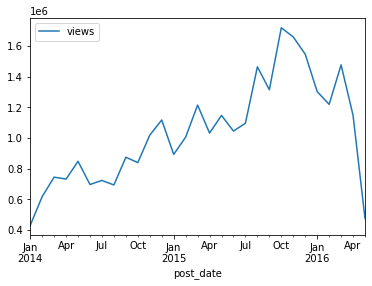

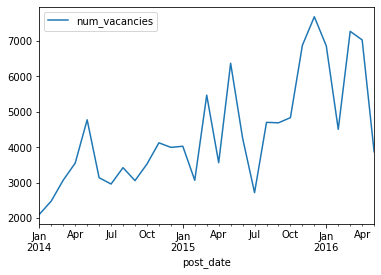

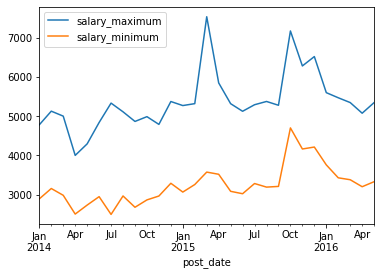

In [ ]:
df = data_clean[['views','num_vacancies',"salary_maximum","salary_minimum"]]
df.index = data_clean['post_date']
df[['views']].resample('m').sum().plot(),
df[['num_vacancies']].resample('M').sum().plot()
df[["salary_maximum","salary_minimum"]].resample('M').mean().plot()
plt.legend()

now we want to know what is the most wanted **job industries** and **job categories**

first we will make a counter to count the frequency

In [ ]:
def counter(column):
    temp = dict()
    for i in range(len(data_clean[column])):
        for j in range(len(data_clean[column][i])):
            if data_clean[column][i][j].strip() in temp :
                temp[data_clean[column][i][j].strip()] += 1
            else:
                temp[data_clean[column][i][j].strip()] = 1
    return temp
counter(column = 'job_industry')

{'Accounting and Auditing Services': 106,
 'Advertising and PR Services': 1419,
 'Aerospace and Defense': 31,
 'Agriculture/Forestry/Fishing/Farming': 208,
 'Airlines/Aviation': 66,
 'Alternative Medicine': 9,
 'Animation': 90,
 'Apparel and Fashion': 109,
 'Architectural and Design Services': 640,
 'Arts and Crafts': 136,
 'Automotive Sales and Repair Services': 186,
 'Automotive and Parts Manufacturing': 192,
 'Aviation and Aerospace': 9,
 'Banking': 244,
 'Biotechnology': 54,
 'Broadcasting': 32,
 'Business Services - Other': 573,
 'Business Supplies and Equipment': 91,
 'Capital Markets': 38,
 'Chemicals/Petro-Chemicals': 235,
 'Clothing and Textile Manufacturing': 39,
 'Components': 339,
 'Computer Games': 104,
 'Computer Hardware': 262,
 'Computer Networking': 272,
 'Computer Software': 3864,
 'Computer and Network Security': 210,
 'Computer/IT Services': 2300,
 'Construction - Industrial Facilities and Infrastructure': 601,
 'Construction - Residential & Commercial/Office': 578,

here we will plot the industry 

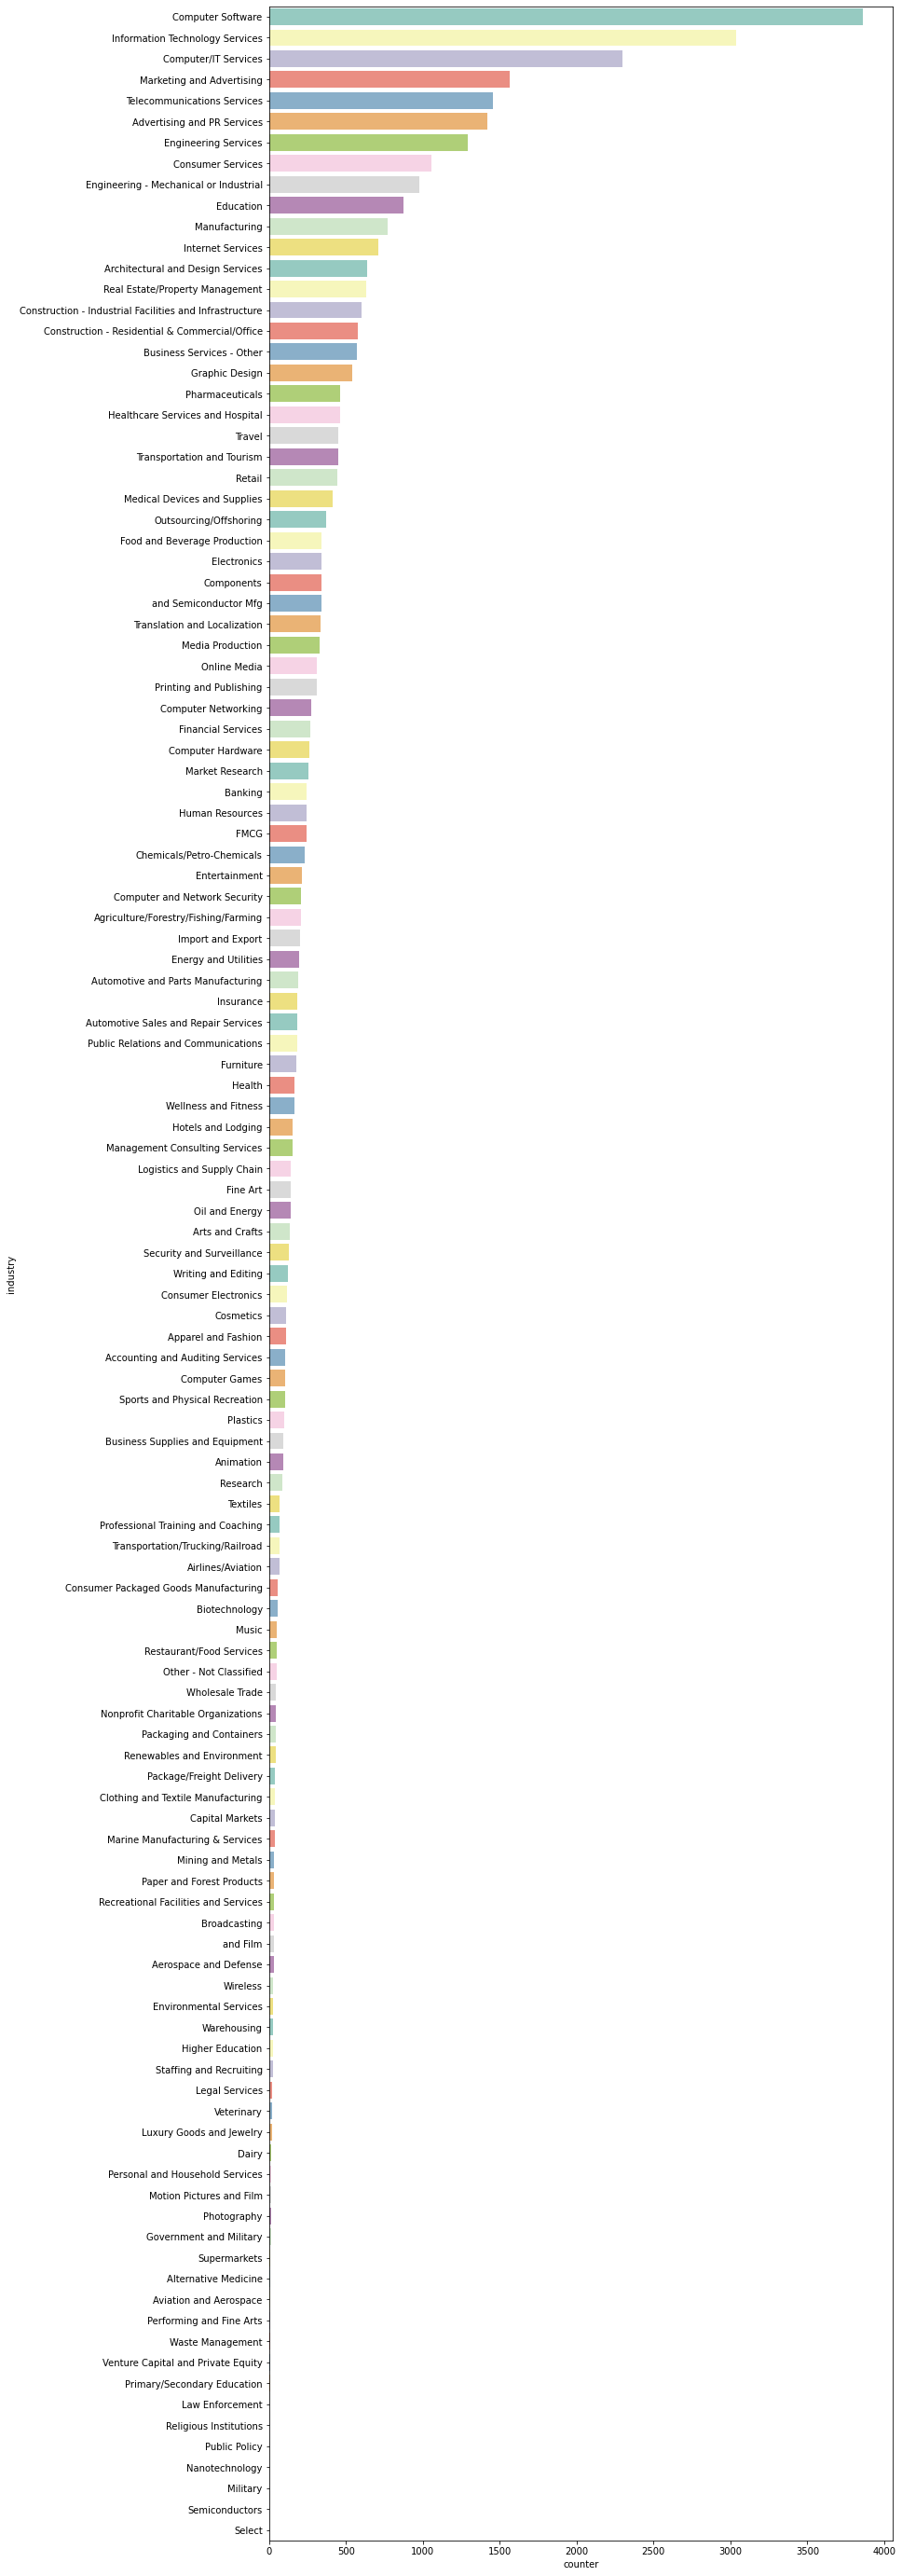

In [ ]:
f, ax = plt.subplots(figsize=(12, 50))
temp = counter('job_industry')
industry_count = pd.DataFrame({'industry':list(temp.keys()),'counter':list(temp.values())})
sns.barplot(x ='counter', y='industry', data=industry_count, palette="Set3",
            order=industry_count.sort_values('counter',ascending = False).industry)
plt.show()

here we will plot the category

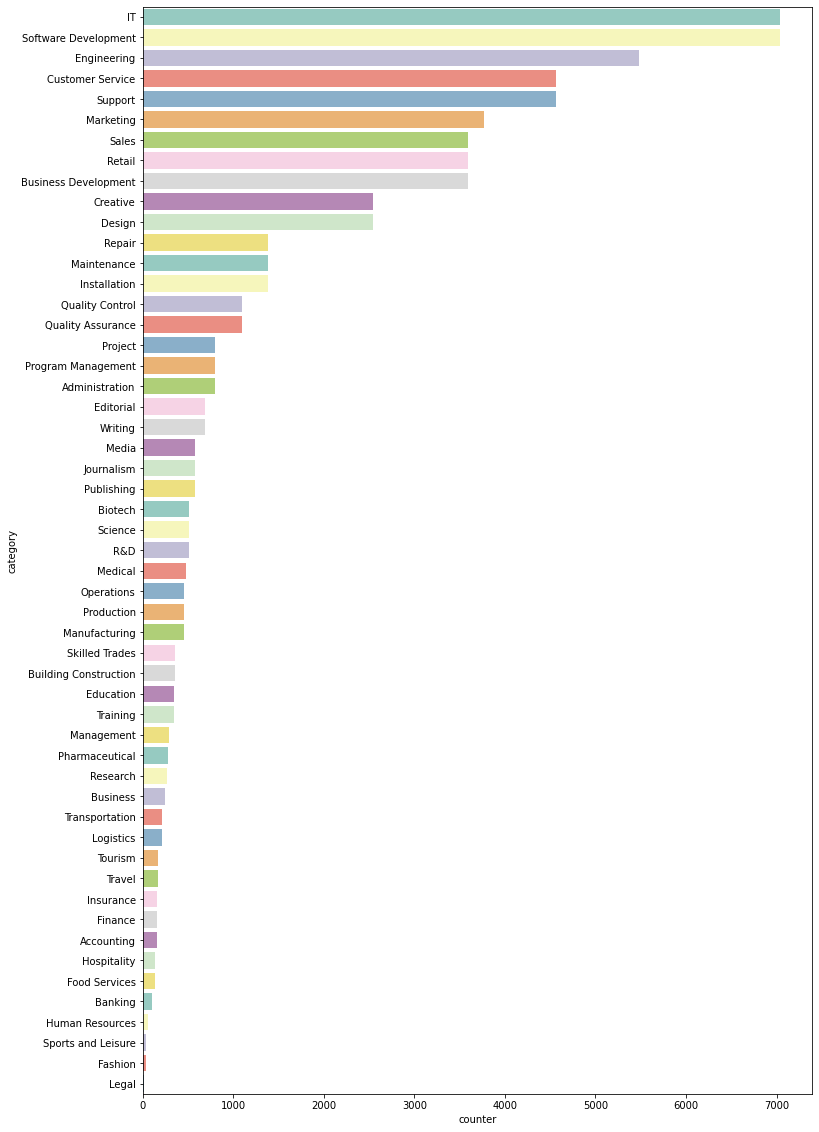

In [ ]:
f, ax = plt.subplots(figsize=(12, 20))
temp = counter('job_category')
category_count = pd.DataFrame({'category':list(temp.keys()),'counter':list(temp.values())})
sns.barplot(x = 'counter', y = 'category', data = category_count, palette = "Set3",
            order = category_count.sort_values('counter',ascending = False).category)
plt.show()

# Part 3 : Applying the algorithm

Here we are going to predict minimum salary using **Decision Tree** Algorithm

we will feed the algorithm the **job_title** **job_catogery** **experience_years** and it will try to predict the minimum salary

At this point we need to clean the data a little bit more.

## Initializing X 

In [ ]:
X = pd.DataFrame({
    'job_title': data_clean['job_title'],
    'job_category': data_clean['job_category'],
    'experience_years': data_clean['experience_years']
  })

In [ ]:
X

,job_title,job_category,experience_years
0,Sales & Marketing Agent,"[Sales , Retail , Business Development , Ma...",0-1
1,German Training Coordinator,"[Customer Service , Support , Administration...",0-2
2,Junior Software Developer,"[IT , Software Development]",2
3,Application Support Engineer,"[IT , Software Development]",1-2
4,Electrical Maintenance Engineer,[Engineering],1-3
...,...,...,...
21845,Creative Designer,"[Creative , Design]",1-4
21846,Health and Safety Manager - Qalyubia,"[Quality Assurance , Quality Control , Biote...",5+
21847,Marketing and Sales specialist,"[Administration , Marketing , Sales , Retai...",<1
21848,E Markting,[Marketing],0-1


We will need to convert the **job_category** to string for the next steps

In [ ]:
# convert job_category and job_industry from list to string
X['job_category'] = X['job_category'].apply(','.join)

In [ ]:
X['job_category'] = X['job_category'].str.strip() # remove white spaces before and after the text

In [ ]:
X

,job_title,job_category,experience_years
0,Sales & Marketing Agent,"Sales , Retail , Business Development , Marketing",0-1
1,German Training Coordinator,"Customer Service , Support , Administration , ...",0-2
2,Junior Software Developer,"IT , Software Development",2
3,Application Support Engineer,"IT , Software Development",1-2
4,Electrical Maintenance Engineer,Engineering,1-3
...,...,...,...
21845,Creative Designer,"Creative , Design",1-4
21846,Health and Safety Manager - Qalyubia,"Quality Assurance , Quality Control , Biotech ...",5+
21847,Marketing and Sales specialist,"Administration , Marketing , Sales , Retail , ...",<1
21848,E Markting,Marketing,0-1


Next we need to encode every string to a unique value so the the algorithm can work.

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Transform string to numerical values to prepare it for decision tree algorithms.
title_encoder = LabelEncoder()
category_encoder = LabelEncoder()
experince_encoder = LabelEncoder()

X['job_title'] = title_encoder.fit_transform(X['job_title'])
X['job_category'] = category_encoder.fit_transform(X['job_category'])
X['experience_years'] = experince_encoder.fit_transform(X['experience_years'])

Converting X to numpy array to work with the algorithm method

In [ ]:
X = X.to_numpy()

In [ ]:
X

array([[6872, 1289,   11],
       [3183,  268,   14],
       [4211,  623,   79],
       ...,
       [4823,   91,  192],
       [2402,  859,   11],
       [5085,  688,  116]])

We will need a function to transform the input string to its equivalent integer value after being encoded

In [ ]:
def strings_to_fitted_integers(details):
  title = title_encoder.transform([details[0]])
  category = category_encoder.transform([details[1]])
  experince = experince_encoder.transform([details[2]])

  return np.array([title, category, experince]).reshape((1,3))

Let's try it

In [ ]:
 strings_to_fitted_integers(['Junior PHP developer', 'IT , Software Development', '0-1'])

array([[4154,  623,   11]])

## Initializing Y

Before we get the salaries there are salaries by dollar and others by egyption pound.

so let's convert all of them to egyption pound by (value * 7.75) 

*7.75 is the value of the dollar in 2014*

In [ ]:
data_clean['salary_minimum'][ data_clean['currency'] == 'United States Dollar' ] = data_clean['salary_minimum'][ data_clean['currency'] == 'United States Dollar' ] * 7.75
data_clean['salary_maximum'][ data_clean['currency'] == 'United States Dollar' ] = data_clean['salary_maximum'][ data_clean['currency'] == 'United States Dollar' ] * 7.75

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now we will drop the **currency** column as we don't need it any

In [ ]:
data_clean.pop('currency')

0        Egyptian Pound
1        Egyptian Pound
2        Egyptian Pound
3        Egyptian Pound
4        Egyptian Pound
              ...      
21845    Egyptian Pound
21846    Egyptian Pound
21847    Egyptian Pound
21848    Egyptian Pound
21849    Egyptian Pound
Name: currency, Length: 21850, dtype: object

We also can notice that the salaries are inconsistent,
there are some hourly salaries and monthly salaries.

we will fix that by replacing every hourly plan with ( hourly value * 6 * 26)

as we will assume here they all work 6 hours a day and 26 days per month.

In [ ]:
data_clean['salary_minimum'][ data_clean['payment_period'] == 'Per Hour' ] = data_clean['salary_minimum'][ data_clean['payment_period'] == 'Per Hour' ] * 6 * 26
data_clean['salary_maximum'][ data_clean['payment_period'] == 'Per Hour' ] = data_clean['salary_maximum'][ data_clean['payment_period'] == 'Per Hour' ] * 6 * 26

Now we will drop the **payment_period** as we don't need it any more

In [ ]:
data_clean.pop('payment_period')

0        Per Month
1        Per Month
2        Per Month
3        Per Month
4        Per Month
           ...    
21845    Per Month
21846    Per Month
21847    Per Month
21848    Per Month
21849    Per Month
Name: payment_period, Length: 21850, dtype: object

In [ ]:
Y = data_clean['salary_minimum'] # the salary we are trying to predict

In [ ]:
Y = Y.astype(int) # converting Y from float to integers

In [ ]:
Y

0        2000
1        1000
2        2000
3        2000
4        5000
         ... 
21845    5000
21846    5000
21847    2000
21848    1000
21849    6000
Name: salary_minimum, Length: 21850, dtype: int64

## Applying the algorithm

In [ ]:
from sklearn import tree

Applying Decision Tree Algorithm

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [ ]:
to_predict = strings_to_fitted_integers(['Web Designer', 'Creative , Design', '3+'])
clf.predict(to_predict)

array([1500])

Let's increase his experince

In [ ]:
to_predict = strings_to_fitted_integers(['Web Designer', 'Creative , Design', '5+'])
clf.predict(to_predict)

array([2500])

Let's see the accuracy

In [ ]:
clf.score(X,Y)

0.8908466819221968

# End